In [1]:
import getpass
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI

from Toolbox import ImageProcessingToolBoxes

model = ChatOpenAI(model="gpt-4o-2024-08-06")

In [ ]:
import tifffile

# 使用 tifffile 检查 TIFF 文件
with tifffile.TiffFile("./test-images/a0085-kme_215.tif") as tiff:
    for page in tiff.pages:
        print("Bits per sample:", page.bitspersample)  # 位深度

In [2]:
test_image_path = './test-images/a0027-IMG_3964.jpg'
output_dir_path = f'./test-output/{os.path.splitext(os.path.basename(test_image_path))[0]}'
image_process = ImageProcessingToolBoxes(image_path=test_image_path, output_dir_name=output_dir_path, debug=True, save_high_resolution=False)
global_style = None

In [ ]:
image_process.get_tool_docs()

In [3]:
response = model.invoke("what is the weather in SF")

In [ ]:
model_with_tool = model.bind_tools([])

In [4]:
response.content

"I'm unable to provide real-time data, including current weather conditions. To get the latest weather information for San Francisco, please check a reliable weather website or app such as the Weather Channel, AccuWeather, or a local news station's website."

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def plot_histogram(
    img_path, 
    bins=256, 
    auxiliary_lines=True,
    line_positions=None
):
    """
    读取图像(可能是8位或16位灰度图)，并绘制类似 Photoshop 风格的直方图。
    - bins: 分桶数，默认256（适用于8位或16位分桶后显示）。
    - auxiliary_lines: 是否添加辅助线（默认 True）
    - line_positions: 辅助线的位置(以 bin 为单位)。如果传入None，则默认在 1/4、1/2、3/4 处。
    返回一个 PIL.Image 对象。
    
    核心逻辑:
      1. 读取图像 (cv2.IMREAD_UNCHANGED) 保留原始深度
      2. 判断 dtype: 8 位 -> [0,256], 16 位 -> [0,65536]
      3. 用 cv2.calcHist 做直方图统计(分桶数=bins)
      4. 用柱状图 bar() 绘制，无坐标刻度，保留外框
      5. 根据需要添加辅助线(axvline)，可自行设置线宽、颜色等
    """
    # 1. 用 UNCHANGED 方式读入，保留原图深度
    image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise ValueError(f"无法读取图像: {img_path}")
    
    # 如果图像是彩色，则转灰度
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 2. 根据图像 dtype 判断是 8 位还是 16 位
    if image.dtype == np.uint8:
        hist_range = [0, 256]      # 8位范围
        hist_bins = bins
    elif image.dtype == np.uint16:
        hist_range = [0, 65536]    # 16位范围
        hist_bins = bins
    else:
        raise ValueError(f"图像不是 8 位或 16 位灰度图，dtype={image.dtype}")
    
    # 3. 计算直方图
    hist = cv2.calcHist([image], [0], None, [hist_bins], hist_range)

    # 4. 创建方形绘图(这里设成 6x6，可根据需要自行修改)
    fig = plt.figure(figsize=(6, 6), facecolor='white')
    ax = fig.add_subplot(111)

    # 5. 使用柱状图
    ax.bar(
        x=range(hist_bins),
        height=hist[:, 0],
        color='black',
        width=1
    )

    # 设置 xlim, ylim
    ax.set_xlim([0, hist_bins])
    ax.set_ylim([0, hist.max() * 1.05])

    # 6. 保留外框，但去掉刻度
    #    可以让外框线更粗一点，以增强对比
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    # 设置外框颜色和线宽
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)  # 让外框线更粗

    ax.set_xticks([])
    ax.set_yticks([])

    # 7. 如果需要辅助线，就添加
    if auxiliary_lines:
        # 如果用户没指定 line_positions，就默认在 1/4、1/2、3/4 处
        if not line_positions:
            line_positions = [
                hist_bins // 4, 
                hist_bins // 2, 
                hist_bins * 3 // 4
            ]
        for x_val in line_positions:
            ax.axvline(
                x=x_val, 
                color='gray', 
                linestyle='--', 
                linewidth=2  # 线条也加粗
            )

    # 8. 转换为 PIL.Image 并返回
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    pil_image = Image.open(buf).copy()

    plt.close(fig)
    buf.close()

    return pil_image

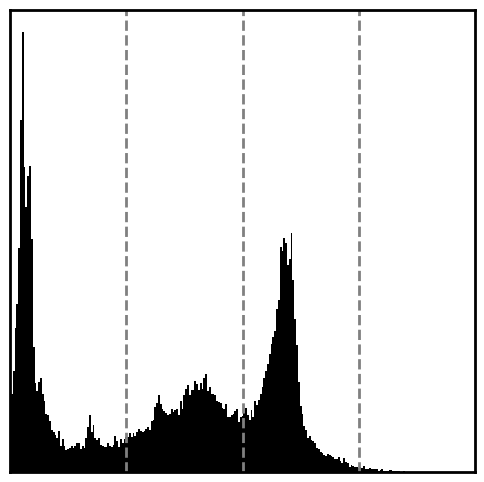

In [5]:
# ------------------------ 使用示例 ------------------------
if __name__ == "__main__":
    # 假设可能是8位jpg，也可能是16位tif
    # 你只需传入路径即可
    hist_pil_8bit = plot_histogram('./test-images/a0105-kme_439.dng')
    display(hist_pil_8bit)

    # hist_pil_16bit = plot_histogram_8bit_or_16bit("test_16bit.tif", bins=256)
    # hist_pil_16bit.show()

    # 若想保存，可自行:
    # hist_pil_8bit.save("output_8bit_hist.png")
    # hist_pil_16bit.save("output_16bit_hist.png")
